https://pypi.org/project/pca/

In [94]:
import sys
import os
import importlib # Used during testing if I need to reload modules

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.stats
import scipy.signal
import pandas as pd

In [95]:
try:
    import ngif_romar.tools as tools
    import ngif_romar.plots.make_plots as plots
    import ngif_romar.plots.plots_tools as plots_tools
except ModuleNotFoundError as error:
    # If not in path/installed, use relative import
    module_path = os.path.abspath(os.path.join("."))
    sys.path.append(module_path)
    import ngif_romar.tools as tools
#    import ngif_romar.plots.make_plots as plots
#    import ngif_romar.plots.plots_tools as plots_tools

In [96]:
dataset_path = os.path.join("..", "data", "SN2", "20201001_1739_")
logfile_path = os.path.join(dataset_path, "Data.dat")
meta_dict, data_df = tools.read_data(logfile_path)
data_df = tools.post_process_log_data(data_df)

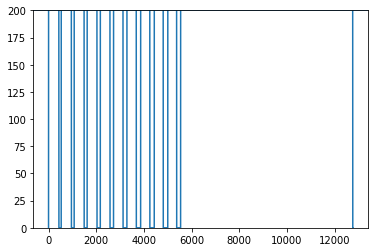

In [97]:
plt.plot(data_df['laser_on_time(ms)'])
plt.ylim([0,200])
plt.axhline(200)

11193

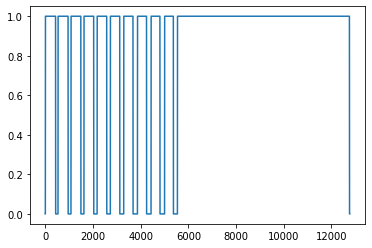

In [98]:
plt.plot(data_df['laser_on_time(ms)'] > 200)
np.count_nonzero(data_df['laser_on_time(ms)'] > 200)

In [99]:
from pca import pca
import numpy as np
data_df_filtered = data_df[
    data_df['laser_on_time(ms)'] > 200
]
print(len(data_df_filtered))
vals = data_df_filtered[['meltpoolSize','meltpoolTemp','flowWatch','protectionGlasTemperature']] # transpose to get column form
# columns are meltpoolSize, meltpoolTemp, flowWatch, glasTemp

11193


In [103]:
model = pca(alpha=0.5,n_components=2) # alpha = threshold for outliers in t2 test
out = model.fit_transform(vals)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.50] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


Text(0.5, 1.0, 'Hotelling t2 ')

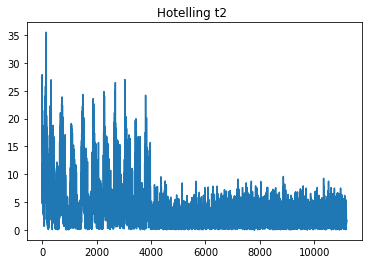

In [109]:
plt.plot(out['outliers']['y_score'].values)
plt.title('Hotelling t2 ')

## Very noisy. If we do the same but pass a rolling window over it beforehand:

In [119]:
vals2 = vals.rolling(10,min_periods=1).mean()

In [120]:
model2 = pca(alpha=0.5,n_components=2) # alpha = threshold for outliers in t2 test
out2 = model.fit_transform(vals2)

[pca] >Cleaning previous fitted model results..
[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.50] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


Text(0.5, 1.0, 'Hotelling t2 ')

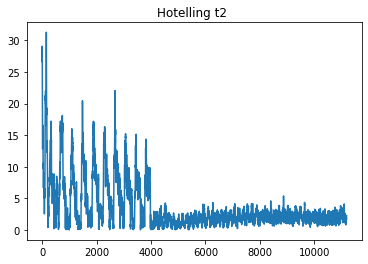

In [121]:
plt.plot(out2['outliers']['y_score'].values)
plt.title('Hotelling t2 ')